# ------------------------------EEG Classification---------------------------------

# Part 1 : Data Preprocessing and Visualization

# Import Required python modules

In [0]:
import pickle as pk
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional,\
BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, \
roc_auc_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight

# Load Data - Raw Signals

In [0]:
#path = '/content/drive/My Drive/Colab Notebooks/DeepLearningAssignment/Data/'
data = open('Data_Raw_signals.pkl','rb')
data_raw = pk.load(data) 
test = open('Test_Raw_signals_no_labels.pkl','rb')
test_raw = pk.load(test)

In [0]:
data = data_raw[0]
labels = data_raw[1]
test_data = test_raw[0]

data = np.reshape(data,(15375,3000,2))
test_data = np.reshape(test_data,(1754,3000,2))

data_whole = np.concatenate((data,test_data),axis=0)

data_whole = np.reshape(data_whole,(17129,6000))

# Standardize Data

In [0]:
from sklearn.preprocessing import StandardScaler

scal = StandardScaler()
data_whole = scal.fit_transform(data_whole)


# Visualization of Single Signal

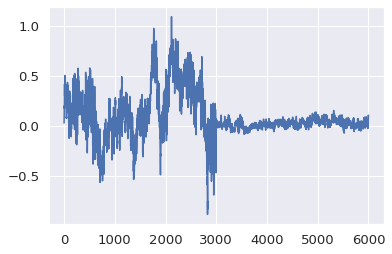

In [7]:
plt.plot(data_whole[175])

In [0]:
train_data = data_whole[:15375]
test_data = data_whole[15375:]

In [0]:
train_data = np.reshape(train_data,(15375,6000*1))
test_data = np.reshape(test_data,(1754,6000*1))

In [0]:
df = pd.DataFrame(train_data)
df['labels'] = labels
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
labels_train = df.pop('labels')
train_data = df[:].values

In [0]:
train_data = np.reshape(train_data,(15375,6000,1))
test_data = np.reshape(test_data,(1754,6000,1))

# Train and Validation Split: (80/20)

In [13]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val = train_test_split(train_data,labels_train, test_size=0.20, random_state=123, shuffle = False)

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(12300, 6000, 1) (12300,) (3075, 6000, 1) (3075,)


In [0]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

# Part 2 : Model Defination and Training

# Calculate Class Weight

In [15]:
keys = np.unique(labels_train)
values = class_weight.compute_class_weight("balanced", keys,labels_train)
cw = dict(zip(keys, values))
print('Class_Weights \n{}'.format(cw))

Class_Weights 
{0: 0.8541666666666666, 1: 0.9932170542635659, 2: 0.8541666666666666, 3: 1.0104495268138802, 4: 1.1141304347826086, 5: 1.3080653394589077}


# Callbacks

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
model_checkpoint = ModelCheckpoint('model_sleepnet.h5', verbose=1, save_best_only=True)

# Model : DeepSleepNet

In [0]:
Fs = 100

def sleepnet(n_classes=6, use_sub_layer=False, summary=True):
    # two conv-nets in parallel for feature learning, 
    # one with fine resolution another with coarse resolution    
    # network to learn fine features

    inputLayer = Input(shape=(6000, 1), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.get_shape()
    convFine = Flatten(name='fFlat1')(convFine)
    
    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.get_shape()
    convCoarse = Flatten(name='cFlat1')(convCoarse)
    
    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    if use_sub_layer:
        sub_layer = Dense(1024, activation="relu", name='sub_layer')(outLayer)
    # model = Model(inputLayer, mergeLayer)
    
    # LSTM
    outLayer = Reshape((1, int(fineShape[1]*fineShape[2] + coarseShape[1]*coarseShape[2])), name='reshape1')(outLayer)
    outLayer = Bidirectional(LSTM(128, activation='relu', dropout=0.5, name='bLstm1'))(outLayer)
    outLayer = Reshape((1, int(outLayer.get_shape()[1])))(outLayer)
    outLayer = Bidirectional(LSTM(128, activation='relu', dropout=0.5, name='bLstm2'))(outLayer)
    
    # merge out_layer and sub_layer
    if use_sub_layer:
        outLayer = concatenate([outLayer, sub_layer], name='merge_2')
        outLayer = Dropout(rate=0.5, name='mDrop2')(outLayer)
        outLayer = Dense(256, activation="relu", name='sub_layer_2')(outLayer)
    outLayer = Dropout(rate=0.5, name='merge_out_sub')(outLayer)
    
    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = keras.optimizers.Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [0]:
model = sleepnet()

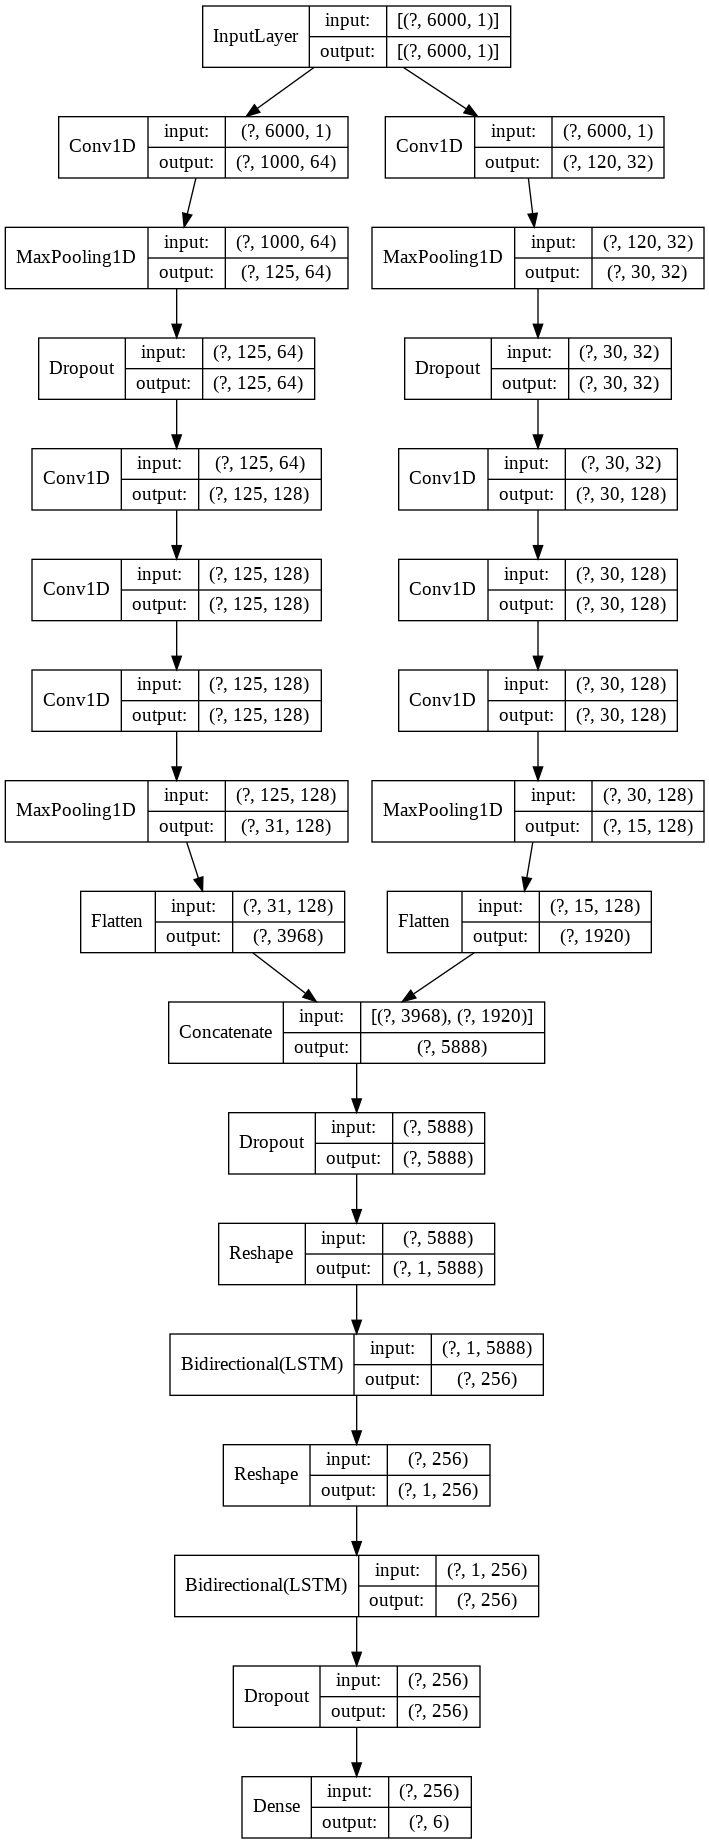

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_layer_names=False, show_shapes=True, )


# Train Model

In [22]:
hist1 = model.fit(X_train, Y_train, epochs=100, validation_data = (X_val, Y_val) , verbose=1,class_weight=cw,callbacks=[early_stopping])

Train on 12300 samples, validate on 3075 samples
Epoch 1/100
12300/12300 [==============================] - 20s 2ms/sample - loss: 1.6947 - acc: 0.1954 - val_loss: 1.4419 - val_acc: 0.4224
Epoch 2/100
12300/12300 [==============================] - 10s 845us/sample - loss: 1.2996 - acc: 0.4294 - val_loss: 1.1866 - val_acc: 0.5076
Epoch 3/100
12300/12300 [==============================] - 11s 854us/sample - loss: 1.1644 - acc: 0.4850 - val_loss: 1.0494 - val_acc: 0.5483
Epoch 4/100
12300/12300 [==============================] - 10s 851us/sample - loss: 1.0583 - acc: 0.5265 - val_loss: 0.9541 - val_acc: 0.5915
Epoch 5/100
12300/12300 [==============================] - 11s 861us/sample - loss: 0.9918 - acc: 0.5609 - val_loss: 1.0108 - val_acc: 0.5558
Epoch 6/100
12300/12300 [==============================] - 10s 851us/sample - loss: 0.9352 - acc: 0.5917 - val_loss: 0.8505 - val_acc: 0.6228
Epoch 7/100
12300/12300 [==============================] - 10s 845us/sample - loss: 0.8881 - acc: 0.6

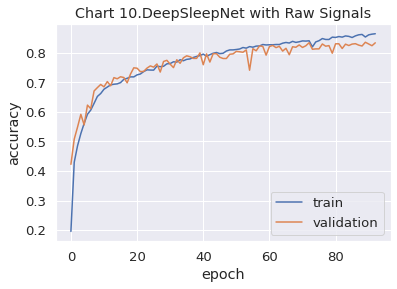

In [23]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Chart 10.DeepSleepNet with Raw Signals')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# Test Data Predictions

In [0]:
X_test = test_data
X_test.shape
result = model.predict(X_test)
final_results = np.argmax(result, axis=-1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/DeepLearningAssignment/Data/answer_final1.txt',final_results)

# References

1.   https://www.kaggle.com/phhasian0710/deepsleepnet-201708
2.   https://github.com/akaraspt/deepsleepnet/tree/master/deepsleep
3.   https://github.com/vlawhern/arl-eegmodels
